In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from performance_analysis import MTOW

In [2]:
#Constantes
NumGeraçôes = 25
NumIndividuos = 20
chance_mutaçao = 0.15 #varia de 0 a 1
perfil = 'E423(120)'
CDo = 0.04 #coeficiente estimado de arrasto parasita
densidade_média_asa = 1.023 #usado para o cálculo do peso vazio, kg/m^2
Elitismo = True
Inseminação = True
Matança = True

In [3]:
#Parâmetros variáveis
bsmin , bsmax = 0.7  , 1.05 #meia parte reta
bmin  , bmax  = 1.6  , 1.6 #meia envergadura
Crmin , Crmax = 0.45  , 0.55 #corda raiz
Ctmin , Ctmax = 0.2  , 0.4 #corda ponta
off_m_min , off_m_max =  0 , 0 #offset no meio
off_p_min , off_p_max =  0 , 0.08 #offset na ponta
perfis = ['E423(120)','E423(120)']

In [4]:
#Genes inseridos artificialmente na primeira geração
Mbs = 1
Mb = 1.6
MCr = 0.6
MCt = 0.25
Moffm = 0
Moffp = 0
#Nao necessariamente a asa final terá esses valores mas o código tenderá a esses intervalos e genes

In [5]:
#Parâmetros climáticos e dinâmicos
velocidade = 20
p = 1.177 #densidade do ar
viscosidade = 0.0000184
h_obs = 0.8 # 0.1m more than the real obstacle
S_max = 55 #m

In [6]:
class Indivíduo():
    def __init__(self, nome, bs, b , Cr, Ct, offset_meio, offset_ponta, perfil, Cromossomo):
        self.nome = nome #cria um atributo a essa classe, quando chamar o nome ele ira receber a variavel 'nome'
        self.bs = bs #reta
        self.b = b # envergadura
        self.Cr = Cr #corda da raiz
        self.Ct = Ct #corda da ponta
        self.offset_meio = offset_meio
        self.offset_ponta = offset_ponta
        self.perfil = perfil
        self.Cromossomo = Cromossomo

        self.clmax = 0
        self.alpha_estol = 0
        self.nota_individuo = 0
        self.bonus = 1
        self.peso_vazio = 0

In [7]:
lista_Individuos = []
'''if Matança == True:
    df = pd.read_csv('planets.csv',sep=',')
else:
    df = pd.read_csv('pistas_dataset.txt',sep=',')
nomes = np.array([df['name']])'''
#nomes = (nomes[0].tolist()) #chamando varios nomes aleatórios de um dataset pronto

if Matança == True:
    BM = 5 #multiplicador de indivíduos da primeira geração
else:
    BM = 1

i = 0
while i < NumIndividuos*BM :
    meia_envergadura_reta =        (np.random.uniform(bsmin ,bsmax, (1))).tolist() #criando valores aleatórios para cada variável
    meia_envergadura = (np.random.uniform(bmin  ,bmax , (1))).tolist()
    corda_raiz =                   (np.random.uniform(Crmin ,Crmax, (1))).tolist()
    corda_ponta =                  (np.random.uniform(Ctmin ,Ctmax, (1))).tolist()
    offset_meio =                  (np.random.uniform(off_m_min , off_m_max, (1))).tolist()
    offset_ponta =                 (np.random.uniform(off_p_min , off_p_max, (1))).tolist()
    perfil_asa =                    perfis[round(random.random())]

    Individuo_cromossomo = [meia_envergadura_reta[0],meia_envergadura[0],corda_raiz[0],corda_ponta[0],offset_meio[0],offset_ponta[0],perfil_asa]
    kernel = Indivíduo('Name',meia_envergadura_reta[0],meia_envergadura[0],corda_raiz[0],corda_ponta[0],offset_meio[0],offset_ponta[0],perfil_asa,Individuo_cromossomo) #criando o indivíduo
    lista_Individuos.append(kernel)

    print(Individuo_cromossomo)
    i+=1

[0.9062795087381569, 1.6, 0.47579169684612216, 0.25437350959493216, 0.0, 0.07596419647098396, 'E423(120)']
[0.7988388729362239, 1.6, 0.4905244960556638, 0.29604554015062967, 0.0, 0.016116489693838762, 'Leia']
[0.755066796415096, 1.6, 0.5396975394359631, 0.36841355390080566, 0.0, 0.014488553862185442, 'E423(120)']
[0.7051580098086229, 1.6, 0.4794930395369969, 0.243791498262598, 0.0, 0.04471663267010852, 'E423(120)']
[1.0231728714977566, 1.6, 0.5288448708250344, 0.36736197180803143, 0.0, 0.06847089118319494, 'E423(120)']
[1.0150118670142392, 1.6, 0.4914417772552064, 0.3222234199806459, 0.0, 0.03483857683862868, 'Leia']
[0.7345488823335744, 1.6, 0.48248488399551337, 0.26272305014195657, 0.0, 0.05980001739599555, 'E423(120)']
[0.9948971074555624, 1.6, 0.5418446732608208, 0.32555963650028663, 0.0, 0.02027178892076153, 'E423(120)']
[0.8471641861185345, 1.6, 0.5438674815584554, 0.3693833025407925, 0.0, 0.015956726195434402, 'E423(120)']
[0.8767262202983765, 1.6, 0.5465173821385313, 0.30289512

In [8]:
def curva_tracao(v):
    return -0.031*(v**2) - 0.213*v + 69.903
def fitness(avaliado):
    asa = [avaliado.Cr,avaliado.Ct,avaliado.bs,avaliado.b-avaliado.bs,avaliado.offset_meio,avaliado.offset_ponta,avaliado.perfil]

    W, AAA , PV = MTOW(asa, curva_tracao, S_max, h_obs, p , velocidade, viscosidade)
    if W >=17:
        W = 17

    return (W - PV*2) # Nota final será o MTOW - o peso vazio

In [9]:
i = 0
while i < NumIndividuos*BM:
    lista_Individuos[i].nota_individuo = fitness(lista_Individuos[i]) #Avaliando primeira geração
    i+=1

lista_Individuos = sorted(lista_Individuos, key=lambda x: x.nota_individuo,reverse=True) #Ordenando primeira geração por nota

if Inseminação == True:
    del lista_Individuos[-1] #excluindo pior individuo da 1° geração
    META = Indivíduo('Io',Mbs,Mb,MCr,MCt,Moffm,Moffp,perfil,[Mbs,Mb,MCr,MCt,Moffm,Moffp,perfil]) #definindo indivíduo artificialmente criado
    META.nota_individuo = fitness(META)
    lista_Individuos.append(META) #adicionando indivíduo criado artificialmente na 1° geração
    lista_Individuos = sorted(lista_Individuos, key=lambda x: x.nota_individuo,reverse=True) #Ordenando primeira geração por nota


lista_Individuos = sorted(lista_Individuos, key=lambda x: x.nota_individuo,reverse=True)

i = 0
while i< NumIndividuos*BM :
    print(lista_Individuos[i].Cromossomo,lista_Individuos[i].nota_individuo)
    i+=1

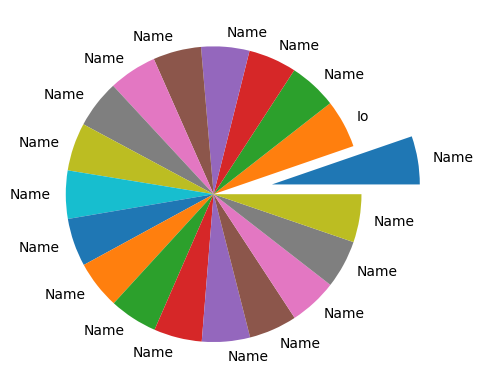

Melhor individuo da primeira geração foi: Name com uma nota de 14.786825795969495


In [ ]:
if Matança == True:

    lista_Individuos = lista_Individuos[:NumIndividuos]
    
    i = 0
    graficoX = []
    graficoY = []
    espace = [0.4] #comando pro melhor individuo ser destacado da roda, efeito visual
    while i<len(lista_Individuos):
        graficoX.append(lista_Individuos[i].nome)
        graficoY.append(lista_Individuos[i].nota_individuo)
        if i >= 2:
            espace.append(0)
        i+=1

    y = graficoY[0:-1]
    mylabels = graficoX[0:-1]
    plt.pie(y,labels=mylabels,explode = espace,shadow=False)
    plt.show()
    print('Melhor individuo da primeira geração foi:',lista_Individuos[0].nome,'com uma nota de',lista_Individuos[0].nota_individuo)
else:
    i = 0
    graficoX = []
    graficoY = []
    espace = [0.4] #comando pro melhor individuo ser destacado da roda, efeito visual
    while i<NumIndividuos*BM:
        graficoX.append(lista_Individuos[i].nome)
        graficoY.append(lista_Individuos[i].nota_individuo)
        if i >= 2:
            espace.append(0)
        i+=1

    y = graficoY[0:-1]
    mylabels = graficoX[0:-1]
    plt.pie(y,labels=mylabels,explode = espace,shadow=False)
    plt.show()
    print('Melhor individuo da primeira geração foi:',lista_Individuos[0].nome,'com uma nota de',lista_Individuos[0].nota_individuo)

In [ ]:
def crossover(selecionado1,selecionado2):
    corte = round(random.random()*6) #criando o corte aleatorio
    if corte == 0: #condicional para o caso de não existir corte, sem possibilidade de clones
        corte = 1 
    corte_Pai = (selecionado1.Cromossomo[0:corte] )
    corte_Mae = (selecionado2.Cromossomo[corte::]) #criando Cromossomos cortados do Pai e da Mae
    filho_cromossomo = corte_Pai + corte_Mae

    bs_filho = filho_cromossomo[0]
    b_filho = filho_cromossomo[1]
    Cr_filho = filho_cromossomo[2]
    Ct_filho = filho_cromossomo[3]
    offset_meio_filho = filho_cromossomo[4]
    offset_ponta_filho = filho_cromossomo[5]

    Filho_novo = Indivíduo('NAME',bs_filho,b_filho,Cr_filho,Ct_filho,offset_meio_filho,offset_ponta_filho,perfil,filho_cromossomo)
    Filho_novo.nota_individuo = fitness(Filho_novo) #avaliando os filhos

    return Filho_novo

In [ ]:
def mutaçao(IndividuoX):
    corte = (round(random.random()*5))

    if corte == 0:  #Condicionais para além de mudar o cromossomo do indivíduo mudar, tbm a sua variavel inicial
        IndividuoX.Cromossomo[corte] = (np.random.uniform(bsmin ,bsmax, (1))).tolist()
        IndividuoX.bs = IndividuoX.Cromossomo[corte][0]

    if corte == 1:
        IndividuoX.Cromossomo[corte] = (np.random.uniform(bmin ,bmax, (1))).tolist()
        IndividuoX.b = IndividuoX.Cromossomo[corte][0]

    if corte == 2:
        IndividuoX.Cromossomo[corte] = (np.random.uniform(Crmin ,Crmax, (1))).tolist()
        IndividuoX.Cr = IndividuoX.Cromossomo[corte][0]

    if corte == 3:
        IndividuoX.Cromossomo[corte] = (np.random.uniform(Ctmin ,Ctmax, (1))).tolist()
        IndividuoX.Ct = IndividuoX.Cromossomo[corte][0]

    if corte == 4:
        IndividuoX.Cromossomo[corte] = (np.random.uniform(off_m_min , off_m_max, (1))).tolist()
        IndividuoX.offset_meio = IndividuoX.Cromossomo[corte][0]

    if corte == 5:
        IndividuoX.Cromossomo[corte] = (np.random.uniform(off_p_min , off_p_max, (1))).tolist()
        IndividuoX.offset_ponta = IndividuoX.Cromossomo[corte][0]

        
    IndividuoX.Cromossomo = [IndividuoX.bs,IndividuoX.b,IndividuoX.Cr,IndividuoX.Ct,IndividuoX.offset_meio,IndividuoX.offset_ponta,perfil] #novo cromossomo após a mutação
    IndividuoX.nota_individuo = fitness(IndividuoX) #avaliado o individuo após a mutação
    

In [ ]:
k = 0
melhores_Individuo_nota = []
melhor_individuo = [lista_Individuos[0]]
lista_NumeroGen = []
while k < NumGeraçôes:
    i = 0
    roda_da_fortuna = []

    while i < NumIndividuos:
        j = 0
        while j < round((lista_Individuos[i].nota_individuo)*1.5):
            roda_da_fortuna.append(lista_Individuos[i]) #adicionando o mesmo individuo varias vezes para o melhor inidividuo ter maior chance de ser cruzado
            j+=1
        i+=1
    l = 0

    lista_Individuos = [] #esvaziar lista para a próxima geração

    while l < NumIndividuos:
        pai = roda_da_fortuna[round(random.random()*(len(roda_da_fortuna)-1))] # seleção do pai
        mae = roda_da_fortuna[round(random.random()*(len(roda_da_fortuna)-1))] # seleção da mãe
        
        Son = crossover(pai,mae) #crossover dos pais selecionados
        
        if random.random() <= chance_mutaçao: #condicional para mutação caso caia na probabilidade
            mutaçao(Son)
            lista_Individuos.append(Son)
        else:
            lista_Individuos.append(Son)

        l+=1
         
    lista_Individuos = sorted(lista_Individuos, key=lambda x: x.nota_individuo,reverse=True)
    lista_NumeroGen.append(k)

    if Elitismo == True: #Caso seja optado por salvar o melhor individuo de cada geração
        del lista_Individuos[-1] #excluindo pior individuo da geração atual
        Best = (melhor_individuo[-1]) #definindo melhor indivíduo da geração passada
        lista_Individuos.append(Best) #adicionando melhor individuo da geração passada na atual
        lista_Individuos = sorted(lista_Individuos, key=lambda x: x.nota_individuo,reverse=True)
    
    melhor_individuo.append(lista_Individuos[0])
    melhores_Individuo_nota.append(lista_Individuos[0].nota_individuo)
    k+=1
    print(lista_Individuos[0].Cromossomo,lista_Individuos[0].nota_individuo)

[0.8012241016592063, 1.6, 0.6, 0.25, 0, 0, 'E423(120)'] 14.819143128838565
[0.8012241016592063, 1.6, 0.6, 0.25, 0, 0, 'E423(120)'] 14.819143128838565
[0.8012241016592063, 1.6, 0.6, 0.25, 0, 0.0, 'E423(120)'] 14.819143128838565
[0.8012241016592063, 1.6, 0.6, 0.25, 0, 0.0, 'E423(120)'] 14.819143128838565
[0.8012241016592063, 1.6, 0.6, 0.25, 0, 0.0, 'E423(120)'] 14.819143128838565
[0.8012241016592063, 1.6, 0.6, 0.25, 0.0, 0.0, 'E423(120)'] 14.819143128838565
[0.8012241016592063, 1.6, 0.6, 0.25, 0.0, 0.0, 'E423(120)'] 14.819143128838565
[0.8012241016592063, 1.6, 0.6, 0.25, 0.0, 0.0, 'E423(120)'] 14.819143128838565
[0.8012241016592063, 1.6, 0.6, 0.25, 0.0, 0.0, 'E423(120)'] 14.819143128838565
[0.8012241016592063, 1.6, 0.6, 0.25, 0.0, 0.0, 'E423(120)'] 14.819143128838565
[0.8012241016592063, 1.6, 0.6, 0.25, 0.0, 0.0, 'E423(120)'] 14.819143128838565
[0.8012241016592063, 1.6, 0.6, 0.25, 0.0, 0.0, 'E423(120)'] 14.819143128838565
[0.8012241016592063, 1.6, 0.6, 0.25, 0, 0.0, 'E423(120)'] 14.81914

KeyboardInterrupt: 

In [ ]:

prova = melhor_individuo
melhor_individuo = sorted(melhor_individuo, key=lambda x: x.nota_individuo,reverse=True) #procura o melhor indivíduo de todas as gerações

gen = prova.index(melhor_individuo[0])

plt.xlabel('N de gerações')
plt.ylabel('Melhor indivíduo')
plt.title('Algoritmo genético')
plt.plot(lista_NumeroGen,melhores_Individuo_nota,'purple')
plt.grid()
plt.show()

print('O melhor indivíduo de todas as gerações foi encontrado primeiramente na geração:', gen)
sw = (prova[gen].bs*prova[gen].Cr) + ((prova[gen].Cr+prova[gen].Ct)*prova[gen].b)/2
print('A secção reta da asa otimizada é ',prova[gen].bs,'m')
print('A meia envergadura da asa otimizada é ',prova[gen].b)
print('A corda na raíz da asa otimizada é ',prova[gen].Cr,'m')
print('A corda na ponta da asa otimizada é ',prova[gen].Ct,'m')
print('O offset da ponta da asa otimizada é ',prova[gen].offset_ponta,'m')
print('O CLmáx da asa otimizada é ',prova[gen].clmax)
print('O Alpha_estol da asa otimizada é ',prova[gen].alpha_estol,'°')
